# Clustering

This notebok is the third of 5 notebooks in total.

**Notebook 3 of 5**

### `EDA`, `Data Preparation`, **`Clustering`**, `Regression`, `Classification`

#### Students in Group 15:

Jake Brady - 19238428

Anirudh Verma - 23120231

Sakina Padghawala - 23011823

Soumadip Patra - 23168471

Tanmay Srivastava - 23118067

**All Students in the group contributed equally**

#### **Layout of Notebook:**
- 0. Import required libraries & Load Dataset
- 1. Modelling the pipeline
- 2. Cluster Analysis


## 0. Import Required Libraries & Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold 
from sklearn import cluster 
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.pipeline import make_pipeline
import warnings; warnings.simplefilter("ignore")
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

Load preprocessed dataset from directory

In [2]:
df = pd.read_csv("./prepped_data.csv")
df.head()

,Unnamed: 0,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Usage_kWh_categorical,isWeekend,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
0,0,-0.048501,-0.023247,0.000000,0.0,-0.774550,0.000000,-0.791667,0,False,False,True,False,False,False,False
1,1,-0.080181,-0.094848,0.000000,0.0,-0.686692,0.000000,-0.645833,0,False,False,True,False,False,False,False
2,2,-0.080181,-0.123921,0.000000,0.0,-0.578460,0.000000,-0.520833,0,False,False,True,False,False,False,False
3,3,-0.057074,-1.074812,1.972347,0.0,0.302350,-505.662402,-0.166667,0,False,False,True,False,False,False,False
4,4,-0.052760,-1.074812,2.015038,0.0,0.302350,-516.274439,-0.125000,0,False,False,True,False,False,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            2190 non-null   int64  
 1   Usage_kWh                             2190 non-null   float64
 2   Lagging_Current_Reactive_Power_kVarh  2190 non-null   float64
 3   Leading_Current_Reactive_Power_kVarh  2190 non-null   float64
 4   CO2                                   2190 non-null   float64
 5   Lagging_Current_Power_Factor          2190 non-null   float64
 6   Leading_Current_Power_Factor          2190 non-null   float64
 7   NSM                                   2190 non-null   float64
 8   Usage_kWh_categorical                 2190 non-null   int64  
 9   isWeekend                             2190 non-null   bool   
 10  Friday                                2190 non-null   bool   
 11  Monday           

`Unnamed: 0` and `Usage_kWh_categorical` are unnecessary features and are dropped.

In [4]:
df_scaled = df.copy()
# drop column 'Usage_kWh_categorical'
df_scaled = df_scaled.drop(['Usage_kWh_categorical', 'Unnamed: 0'], axis=1)

### Scatterplot Function (to be used below for visualising a clustering)


The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [5]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## 1. Modelling - pipeline

### K-means clustering

### Determinig the optimal number of clusters using Elbow Method

*Plot the sum of squared distances from the data points to the k-Means clusters' centres for various values of k. Using the Elbow method to pick the best value of k. If it suggests a different value of k, compute a new k-Means clustering.*

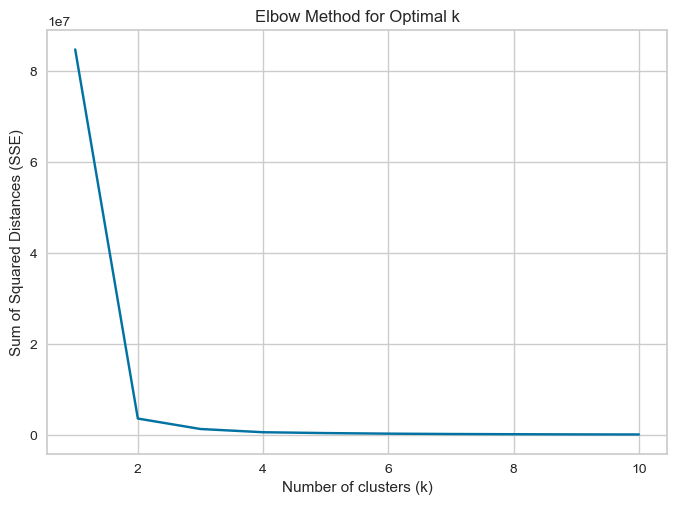

In [6]:
# Elbow method
# Sum of squared distances of samples to their closest cluster center.
inertias = []
k_values = range(1, 11)  # range of k values to try

for k in k_values:    
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    pipe = make_pipeline(kmeans)
    pipe.fit_predict(df_scaled)
    inertias.append(pipe[0].inertia_)

# Plotting the elbow curve
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

## Conclusion
  
- From Elbow method, we found that optimal value of k is 2. 
- Silhouette_score will be used to evaluate model

#### Building pipeline for K=2

In [7]:
# We can use k-means directly, since data is scaled
k=2
pipe = make_pipeline(cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))

In [8]:
pipe

Pipeline(steps=[('kmeans', KMeans(n_clusters=2, n_init=10))])

In [9]:
clusters = pipe.fit(df_scaled)

Append the cluster centers to the dataset.

In [10]:
data_and_centers = np.r_[df_scaled,clusters[0].cluster_centers_]

In [11]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_scaled)

KMeans(n_clusters=2, random_state=42)

In [12]:
df['cluster_label'] = kmeans.labels_
print("Number of samples in each cluster:")
print(df['cluster_label'].value_counts())

Number of samples in each cluster:
cluster_label
0    1749
1     441
Name: count, dtype: int64


#### Visualize the Elbow method to select the optimal value of k

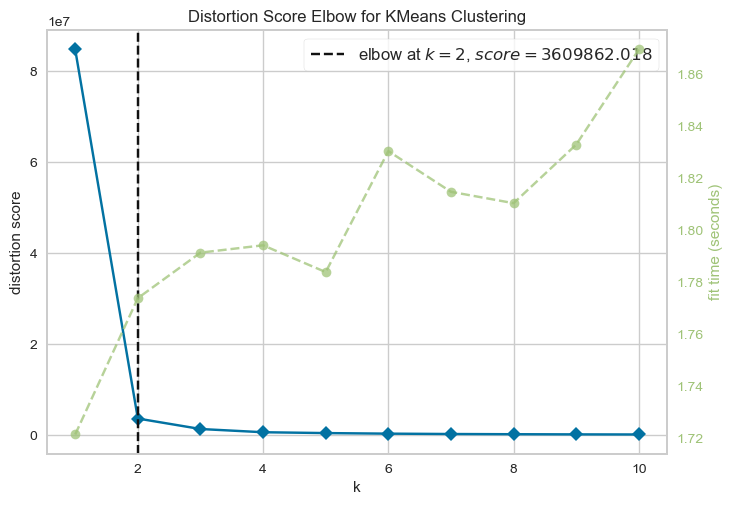

In [13]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(df_scaled)    # Fit the data to the visualizer
visualizer.show();

In [14]:
optimal_k_elbow = visualizer.elbow_value_
print("Optimal number of clusters (k) based on Elbow method:", optimal_k_elbow)

Optimal number of clusters (k) based on Elbow method: 2


#### Apply MDS to project both data and k-Means cluster center to a 2D space¶

Project both the data and the k-Means cluster centers to 2D.

In [15]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("Transformation completed")

Transformation completed


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

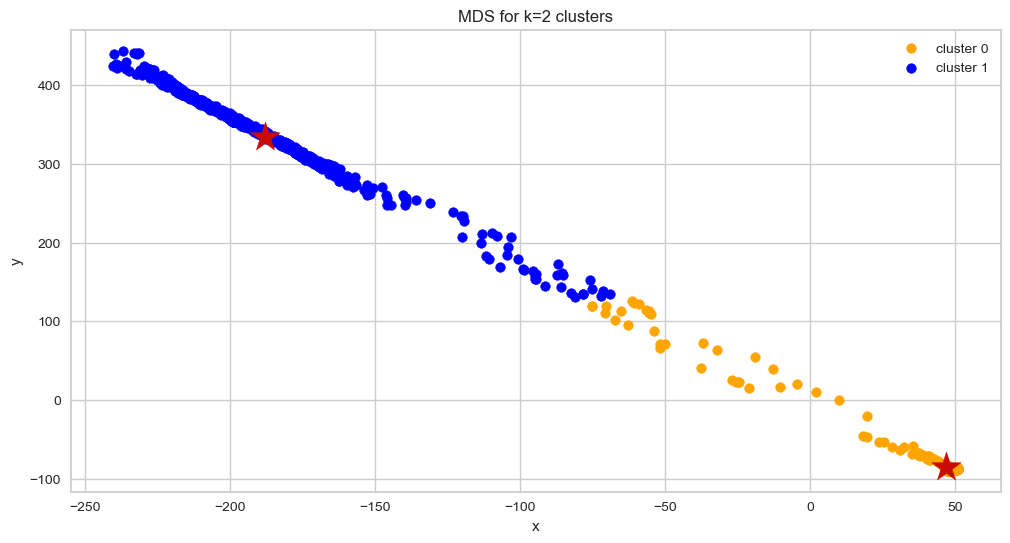

In [16]:
# Plotting the clusters
plt.figure(figsize=(12, 6))
k=2
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clusters[0].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS for k={} clusters'.format(k))

#### Apply t-SNE to project both data and k-means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [17]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

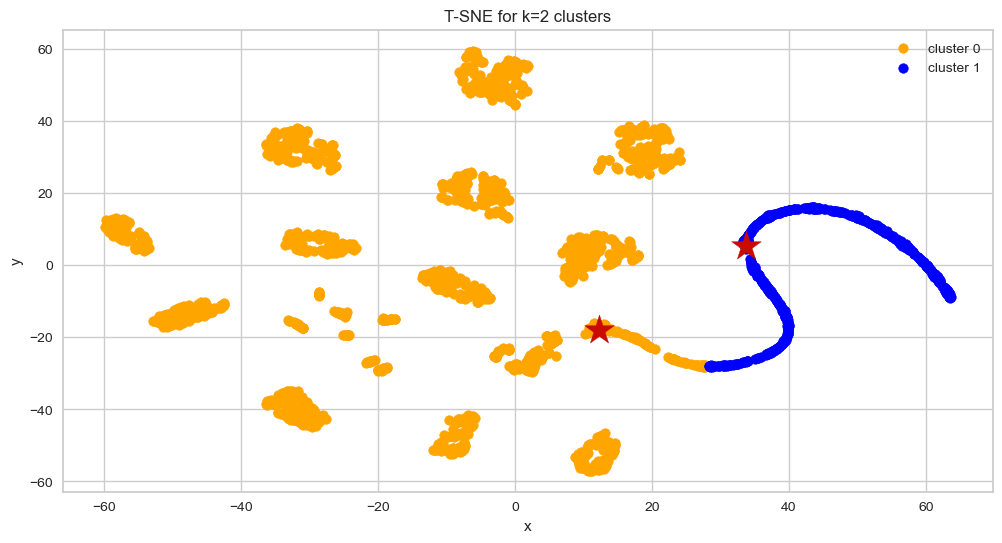

In [18]:
# Plotting the clusters
plt.figure(figsize=(12, 6))

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clusters[0].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='T-SNE for k={} clusters'.format(k))

#### Using Silhouette Method for best value of k

In [19]:
labels = clusters[0].labels_
silhouette_score(df, labels, metric='euclidean')

0.21441392144045876

compare silhouette scores with baseline scores

In [20]:
## compare silhouette scores with baseline scores
n_samples = df_scaled.shape[0]
n_clusters = 2
random_labels = np.random.randint(0,n_clusters, size=n_samples)

# compute silhouette score for random labels
random_silhoutte_score = silhouette_score(df_scaled, random_labels, metric='euclidean')
random_silhoutte_score

-0.0001604035427786557

### Conclusion

  -  Silhouette_score has been compared with baseline randomly assigned clusters.
  -  Silhoutte_score for k=2 is much higher than the baseline random clusters.

However, we will also calculate silhoutte score for different number of clusters

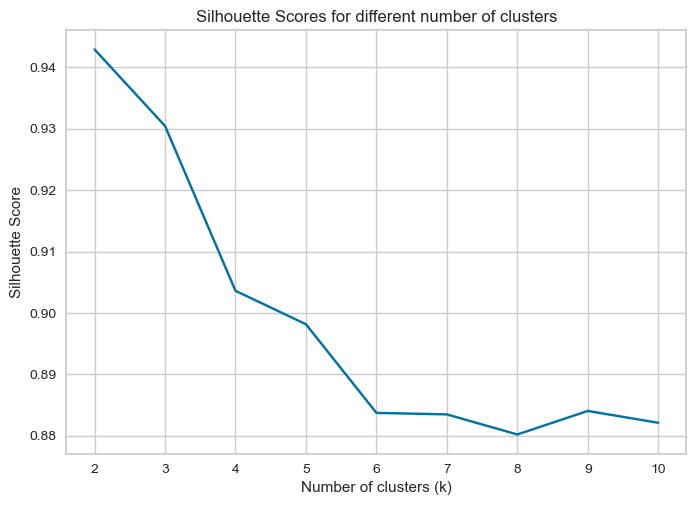

In [21]:
### compare silhouette scores for different number of clusters
silhouette_scores = []
k_values = range(2, 11)  # range of k values to try

for k in k_values:
    pipe = make_pipeline(cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
    clusters = pipe.fit(df_scaled)
    labels = clusters[0].labels_
    silhouette_scores.append(silhouette_score(df_scaled, labels, metric='euclidean'))

# Plotting the silhouette scores
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for different number of clusters')
plt.show()


In [22]:
silhouette_scores[0]

0.942909368156631

### Observation
   - From the above graph, it is indicated that for k= 2, silhoutte score is 0.943.


#### Determine the optimal k using the silhouette scores

In [23]:
# Determine the optimal k using the silhouette scores
optimal_k = k_values[np.argmax(silhouette_scores)]
print("Optimal number of clusters (k) based on Silhouette method:", optimal_k)

Optimal number of clusters (k) based on Silhouette method: 2


Silhouette Coefficient Method:

In [24]:
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df_scaled, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.942909368156631
For n_clusters=3, The Silhouette Coefficient is 0.9304473491313763
For n_clusters=4, The Silhouette Coefficient is 0.9035984273095701
For n_clusters=5, The Silhouette Coefficient is 0.898149089896992
For n_clusters=6, The Silhouette Coefficient is 0.8815914715019856
For n_clusters=7, The Silhouette Coefficient is 0.8834686456659376
For n_clusters=8, The Silhouette Coefficient is 0.8803172835835849
For n_clusters=9, The Silhouette Coefficient is 0.8801176951454103
For n_clusters=10, The Silhouette Coefficient is 0.8820881334192233


As we can see, n_clusters=2 has highest Silhouette Coefficient. This means that 2 should be the optimal number of cluster

_Note: The coefficient value is not constant and it changes everytime._

Comparing the results:

In [25]:
# Compare the results of the Elbow method with the results of the Silhouette method
print("Comparison of Elbow method and Silhouette method:")
print("Elbow method suggests k =", optimal_k_elbow)
print("Silhouette method suggests k =", silhouette_scores.index(max(silhouette_scores)) + 2)

Comparison of Elbow method and Silhouette method:
Elbow method suggests k = 2
Silhouette method suggests k = 2


Elbow curve and Silhouette plots both are very useful techniques for finding the optimal K for k-means clustering.

**The silhouette method and elbow method are in harmony for the optimal number of clusters. `k=2` is Optimal.**

### Building pipeline for k=2

Now, as per the suggested way we will build the pipeline with the optimal value of k for k-means clustering that is with k=2

In [26]:
k2_pipe = make_pipeline(cluster.KMeans(n_clusters=2, n_init=10, max_iter=300))

In [27]:
k2_clusters = k2_pipe.fit(df_scaled)

In [28]:
k2_data_and_centers = np.r_[df_scaled,k2_clusters[0].cluster_centers_]

#### Apply MDS & T-SNE to project both data and k-Means cluster center to a 2D space¶

Applying MDS technique

In [29]:
k2_XYcoordinates = manifold.MDS(n_components=2).fit_transform(k2_data_and_centers)
print("transformation complete")

transformation complete


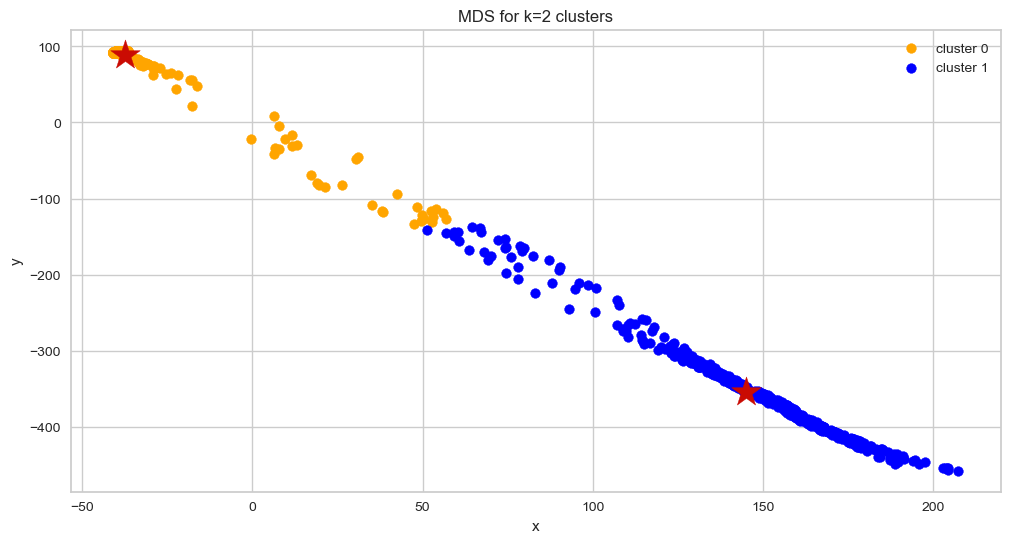

In [30]:
# Plotting the clusters
plt.figure(figsize=(12, 6))
k=2
clustering_scatterplot(points=k2_XYcoordinates[:-k,:], 
                       labels=k2_clusters[0].labels_, 
                       centers=k2_XYcoordinates[-k:,:], 
                       title='MDS for k={} clusters'.format(k))

Applying T-SNE technique

In [31]:
k2_XYcoordinates = manifold.TSNE(n_components=2).fit_transform(k2_data_and_centers)
print("transformation complete")

transformation complete


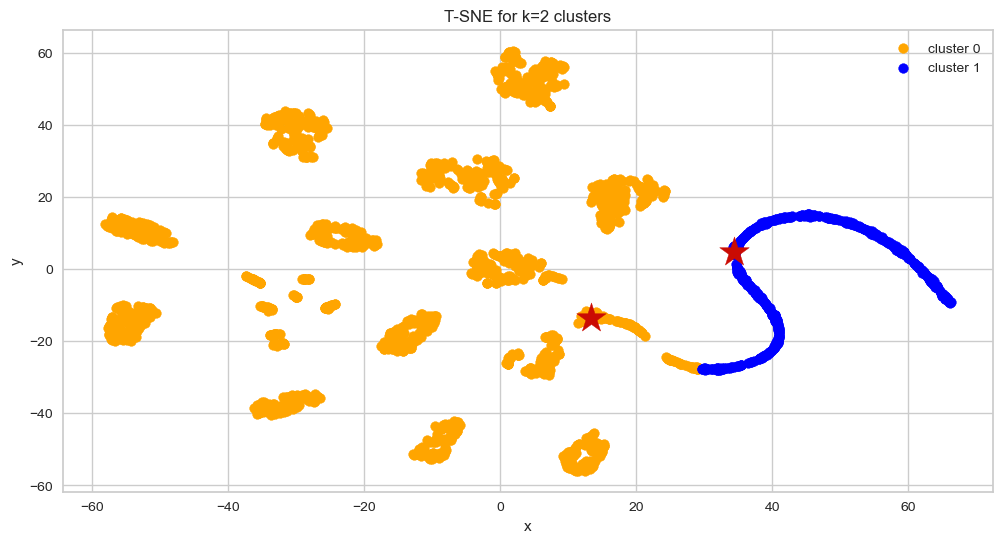

In [32]:
# Plotting the clusters
plt.figure(figsize=(12, 6))

k=2
clustering_scatterplot(points=k2_XYcoordinates[:-k,:], 
                       labels=k2_clusters[0].labels_, 
                       centers=k2_XYcoordinates[-k:,:], 
                       title='T-SNE for k={} clusters'.format(k))

### Applying additional clustering algorithm - Agglomerative

Apply another clustering algorithm (from the ones available in scikit-learn) to the same dataset and an appropriate manifold-learning technique to visualise the clustering

We apply the Agglomerative Clustering algorithm to the data and applying a manifold-learning technique to visualise the clustering

Agglomerative Clustering for K=2

In [33]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

In [34]:
# Agglomerative clustering with pipeline

pipe_agglomerative = AgglomerativeClustering(n_clusters=2)  # Adjust the number of clusters as needed
agglomerative_clusters = pipe_agglomerative.fit_predict(df_scaled)


In [35]:
unique_labels = np.unique(agglomerative_clusters)

# Initialize array to store cluster centers
cluster_centers = np.zeros((len(unique_labels), df.shape[1]))

# Compute cluster centers
for i, label in enumerate(unique_labels):
    cluster_points = df[agglomerative_clusters == label]  # Get points belonging to the cluster
    cluster_center = np.mean(cluster_points, axis=0)  # Compute mean along each feature
    cluster_centers[i] = cluster_center

print(cluster_centers)

[[ 1.11918776e+03 -2.40788141e-02 -1.03785523e+00  1.95550202e+00
   2.34426316e-02  2.96816434e-01 -4.62826558e+02  3.92580872e-01
   0.00000000e+00  5.33755274e-01  9.70464135e-02  1.07594937e-01
   2.19409283e-01  7.17299578e-02  1.03375527e-01  8.64978903e-02
   9.30379747e-01]
 [ 1.08768065e+03  4.85081732e-01  3.64093730e-01  1.09507895e-01
   5.79159161e-01 -4.00922785e-01 -4.99069805e-01 -1.13599942e-01
   5.02331002e-01  2.04545455e-01  1.67249417e-01  1.53846154e-01
   1.14219114e-01  1.63170163e-01  1.62004662e-01  1.49184149e-01
   0.00000000e+00]]


In [36]:
# Convert DataFrame to NumPy array
df_scaled_array = df_scaled.values

In [37]:
# MDS
#agglomerative_data_and_centers = np.r_[df_scaled, cluster_centers]
mds = MDS(n_components=2)
agglomerative_data_and_centers = mds.fit_transform(df_scaled.values, cluster_centers)

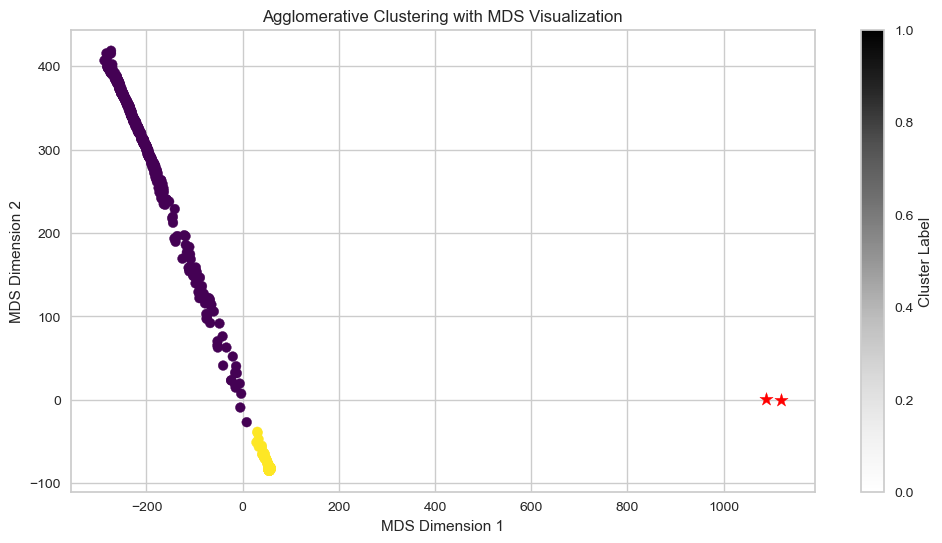

In [38]:
# visualize the clusters

plt.figure(figsize=(12, 6))
plt.scatter(agglomerative_data_and_centers[:, 0], agglomerative_data_and_centers[:, 1], c=agglomerative_clusters, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='*', s=100, label='Cluster Centers')
plt.title('Agglomerative Clustering with MDS Visualization')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

# 3. Cluster Analysis

In [39]:
df_scaled['cluster'] = agglomerative_clusters
df_summary = df_scaled.groupby('cluster').median()

In [40]:
df_summary

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,isWeekend,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
cluster,,,,,,,,,,,,,,
0,-0.05276,-1.074812,1.977397,0.000000,0.302350,-488.658168,0.458333,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.61971,0.082994,0.000000,0.793701,-0.218819,0.000000,-0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 0 has a low `Usage_kWh`

Cluster 0 has a much lower `Lagging_Current_Reactive_Power_kVarh`

Cluster 0 has a much higher `Leading_Current_Reactive_Power_kVarh`

Cluster 0 has a much lower `CO2`

Cluster 0 has a much higher `Lagging_Current_Power_Factor`

Cluster 0 has a much lower `Leading_Current_Power_Factor`

Cluser 0 is far more likely to be a weekend Day

Cluster 0, more likely a weekend day, aligns with observations made during EDA. There is less overall energy consumed on a weekend day likely due to factory workers being off work. This results in a lower overall energy usage in this cluster and hence a lower `Usage_kWh`. A consequence of that is the lower `CO2` found in the same cluster. We expect to see a direct proportionality there.

Power factor is the ratio of real power to apparent power, indicating whether there is leading or lagging power. This directly indicated whether a load is primarily inductive (leading) or capacitive (lagging). We expect these features to be inversely proportion. Without exploring the intricate details of electrical power and current, it is hard to describe the significance of these features. However, it can be noted that understanding the variance of these values will lead the Steel Company to increasing Power Usage Efficiency.

